## Monte Carlo Methods and Non-standard Standard Errors with Bootstrapping

- Economists have sometimes been accused of "physics envy"
    - An overreliance on fancy math derivations and analytical solutions
- And old anecdote goes:
    - Once a competition was held to see who could solve a particular math problem the fastest
    - Physicists and economists were asked for their solutions
    - Economists spent weeks deriving an analytical solution
    - Physicists simply ran simulations on a computer 1,000,000 and got a correct, approximate answer in a few hours
- Monte Carlo methods provide a powerful alternative
- Monte Carlo methods embrace simulation
    - Instead of deriving an analytical solution, we simulate data from a known process
    - Then we estimate our model on the simulated data
    - Repeating this many times gives us an empirical distribution of estimates


## Why Simulation?

- Econometric problems are hard...
- Models become complex and analytical solutions may not be feasible
- The Analytical Limit: Standard econometric theory relies on asymptotic properties (e.g., $N \to \infty$).
- The Reality: We often work with finite samples, complex estimators, or clustered data where analytical variance formulas are intractable or unreliable.
- The Solution: Use computational power to approximate sampling distributions.
- Monte Carlo: We define the Data Generating Process (DGP).
- Bootstrap: We estimate the DGP from the data itself.

## Monte Carlo Methods

- A computational algorithm that relies on repeated random sampling to obtain numerical results.
- In Econometrics: We use MC to understand the properties of an estimator (unbiasedness, consistency, efficiency) because we control the truth.
- Example:
    - Verifying if an estimator works under specific violations (e.g., "How bad is OLS if errors are heteroskedastic?").
    - Power analysis for experimental design.
    - Testing new software packages or algorithms.
- Monte Carlo is a useful tool to have because it allows you to better understand the properties of estimators in complex settings.

## The Basic Loop for Monte Carlo

1. Define the DGP: Set parameters ($\beta$, $\sigma^2$) and distribution of error terms ($u \sim N(0,1)$).
2. Generate Data: Create independent variables ($X$) and calculate $Y = X\beta + u$.
3. Estimate: Run the model on this synthetic data and store the statistic of interest (e.g., $\hat{\beta}$).
4. Repeat: Loop $R$ times (e.g., $R=1000$).
5. Analyze: Plot the distribution of the $R$ stored estimates.

Does the mean of $\hat{\beta}$ equal the true $\beta$?  This is a question can answer because you KNOW the true $\beta$ in your DGP!

## But before that...

- How do we run regressions in Python?
- There are many packages, but we will use `statsmodels`.
- Statsmodels provides two ways of running OLS:
    - The formula API (similar to R's `lm()` function).
    - The object-oriented API (more flexible for programming).
- The steps for running a regression using the object-oriented API are:
    1. Import the package: `import statsmodels.api as sm`
    2. Prepare your data: Ensure your independent variables include a constant term if needed.
    3. Create the model: `model = sm.OLS(y, X)`
    4. Fit the model: `results = model.fit()`
    5. Access results: Use `results.params`, `results.bse`, `results.conf_int()`, etc.
- To adjust standard errors for heteroskedasticity, use:
    - `model_het = model.get_robustcov_results(cov_type='HC1')`
    - or:
        - `results_het = model.fit(cov_type='HC1')`

## The Meat of Monte Carlo

- I'm about to show you a simple regression model where I know the true parameters.
- Then I generate data from that model, estimate it, and store the results.
- This is basically the meat of any Monte Carlo simulation.
    - You create the DGP with random data and then you estimate it.
    


In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

X = np.random.normal(0, 1, 100)
u = np.random.normal(0, 1, 100)
y = 10 + 2 * X + u  # True beta is 2, intercept is 1

# Why is it okay to just write 1 here?

model = sm.OLS(y, X).fit()
# Why is this wrong?
# we need to add a constant to X
# X = sm.add_constant(X)
# model = sm.OLS(y, X).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.014
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              1.450
Date:                Tue, 20 Jan 2026   Prob (F-statistic):                       0.231
Time:                        13:57:47   Log-Likelihood:                         -372.43
No. Observations:                 100   AIC:                                      746.9
Df Residuals:                      99   BIC:                                      749.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [3]:
# Now with the formula API

data = {"y": y, "X": X}
model_formula = smf.ols("y ~ X", data=data).fit()
# constant is automatically added in formula API

print(model_formula.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     337.6
Date:                Tue, 20 Jan 2026   Prob (F-statistic):           1.64e-33
Time:                        13:57:47   Log-Likelihood:                -140.50
No. Observations:                 100   AIC:                             285.0
Df Residuals:                      98   BIC:                             290.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9983      0.100    100.178      0.0

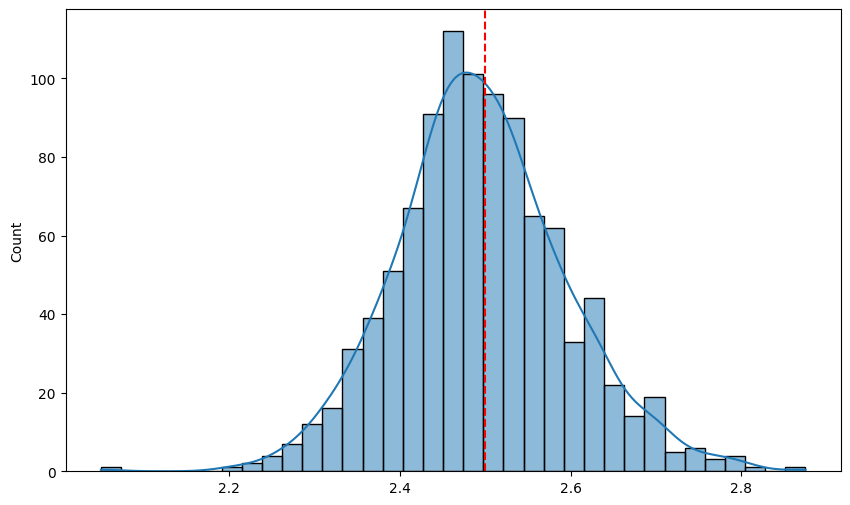

In [4]:
# A Simple Example

import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define DGP
beta_true = 2.5
n_samples = 100
R = 1000

results = {"beta": [], "se": [], "ci": []}

for _ in range(R):
    # 2. Generate Data
    x = np.random.normal(0, 1, n_samples)
    u = np.random.normal(0, 1, n_samples)
    y = beta_true * x + u

    # 3. Estimate
    model = sm.OLS(y, x).fit()
    results["beta"].append(model.params[0])
    results["se"].append(model.bse[0])
    results["ci"].append(model.conf_int(alpha=0.05))


fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(results["beta"], kde=True, ax=ax)
ax.axvline(beta_true, color="red", linestyle="--", label="True β")

## Standard Errors

- Monte Carlo methods give us estimates of the sampling distribution of an estimator.
- You can see from above that the standard deviation of the estimates across simulations provides an empirical standard error.
- Does this align with the theoretical standard error derived analytically?
- What about confidence intervals?
- The confidence interval can be constructed from the empirical distribution of estimates.
- This is particularly useful when the theoretical distribution is unknown or complex.
- Just use the percentiles of the empirical distribution to form confidence intervals.
    - For 95% CI, use the 2.5th and 97.5th percentiles of the estimates.

In [5]:
print("Standard Deviation of betas:", np.std(results["beta"]))
print("Average Standard Error:", np.mean(results["se"]))

print(
    "2.5 and 97.5 percentiles of estimates:",
    np.percentile(results["beta"], [2.5, 97.5]),
)
print("Average Confidence Interval:", np.mean(results["ci"], axis=0))


Standard Deviation of betas: 0.09937249305763395
Average Standard Error: 0.10072695797304686
2.5 and 97.5 percentiles of estimates: [2.3073628  2.70089533]
Average Confidence Interval: [[2.29480154 2.69452981]]


- This is a powerful result, because it gives us an equivalence that we can use to understand estimators.
- There is direct link between looping through simulations and using the resulting distribution, and the analytical formulas for standard errors and confidence intervals.

## Verifying the Need for Heteroskedasticity-Robust SEs

- Let's say we suspect heteroskedasticity in our data.
- We can use Monte Carlo to see how OLS SEs perform under heteroskedasticity.
- Define a DGP with heteroskedastic errors (e.g., $Var(u|X) = \sigma^2 X^2$).
- Run OLS on simulated data and compare standard errors:
    - Regular OLS SEs vs. Heteroskedasticity-Robust SEs.
- Analyze the coverage of confidence intervals constructed using both SEs.

- Exercise: 
1. Adapt the code above to implement this simulation.
2. Plot the resulting distribution
3. Compare the standard deviation of the estimates to the average standard error reported by OLS.


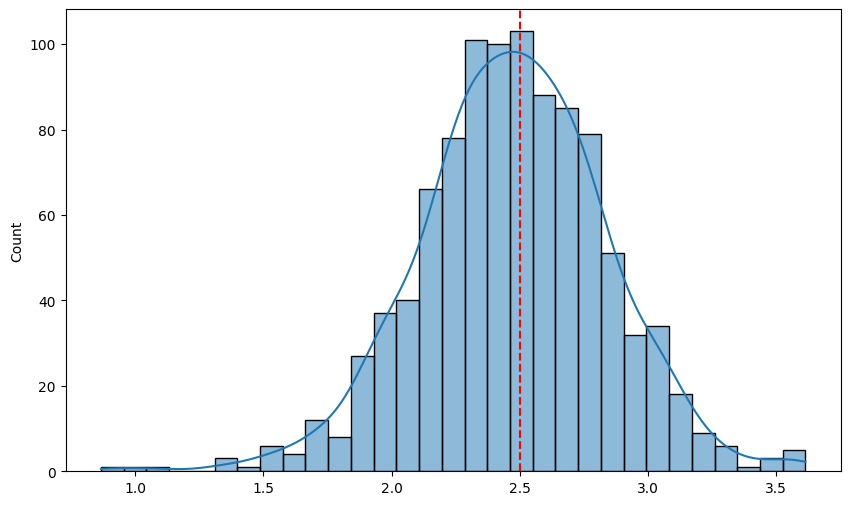

In [6]:
# A Simple Example

import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define DGP
beta_true = 2.5
n_samples = 100
R = 1000

results = {"beta": [], "se": [], "ci": [], "se_het": [], "ci_het": []}

for _ in range(R):
    # 2. Generate Data
    x = np.random.normal(0, 1, n_samples)
    u = np.random.normal(0, x**2, n_samples)
    y = beta_true * x + u

    # 3. Estimate
    model = sm.OLS(y, x).fit()

    # 4. Estimate with robust SEs
    model_het = model.get_robustcov_results(cov_type="HC1")

    results["beta"].append(model.params[0])
    results["se"].append(model.bse[0])
    results["ci"].append(model.conf_int(alpha=0.05))
    results["se_het"].append(model_het.bse[0])
    results["ci_het"].append(model_het.conf_int(alpha=0.05))


fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(results["beta"], kde=True, ax=ax)
ax.axvline(beta_true, color="red", linestyle="--", label="True β")

In [7]:
print("Standard Deviation of betas:", np.std(results["beta"]))
print("Average Homoskedastic Standard Error:", np.mean(results["se"]))
print("-" * 40)
## They're off!
print(
    "2.5 and 97.5 percentiles of estimates:",
    np.percentile(results["beta"], [2.5, 97.5]),
)
print("Average Homoskedastic Confidence Interval:", np.mean(results["ci"], axis=0))
print("-" * 40)

print("Average Heteroskedasticity-Robust Standard Error:", np.mean(results["se_het"]))
print(
    "Average Heteroskedasticity-Robust Confidence Interval:",
    np.mean(results["ci_het"], axis=0),
)

Standard Deviation of betas: 0.3644492263508169
Average Homoskedastic Standard Error: 0.16147037726497154
----------------------------------------
2.5 and 97.5 percentiles of estimates: [1.73516971 3.16551523]
Average Homoskedastic Confidence Interval: [[2.15294235 2.79372687]]
----------------------------------------
Average Heteroskedasticity-Robust Standard Error: 0.3310481398501924
Average Heteroskedasticity-Robust Confidence Interval: [[1.81646328 3.13020594]]


- The standard errors were way too small because of heteroskedasticity.
- But the heteroskedasticity-robust standard errors were much closer to the true standard deviation of the estimates.
- A standard way to diagnose a problem with standard errors and confidence intervals is to look at coverage
- A 95% confidence interval should contain the true parameter 95% of the time. It should "cover" the true parameter 95% of the time.
- If the coverage is significantly lower than 95%, it indicates that the standard errors are underestimated, leading to overly narrow confidence intervals.
- Let's calculate the coverage for the above example

In [14]:
# calculate coverage probability

for ci in results["ci"]:
    # print(ci[0])
    coverage_hom = np.mean([
        (ci[0][0] <= beta_true <= ci[0][1]) for ci in results["ci"]
    ])
    coverage_het = np.mean([
        (ci[0][0] <= beta_true <= ci[0][1]) for ci in results["ci_het"]
    ])

print("Coverage Probability (Homoskedastic):", coverage_hom)
print("Coverage Probability (Heteroskedasticity-Robust):", coverage_het)

Coverage Probability (Homoskedastic): 0.644
Coverage Probability (Heteroskedasticity-Robust): 0.935


## Over- and Under- coverage

- If your confidence intervals contain the true parameter less than the nominal level (e.g., 95%), this is called "undercoverage."
    - Indicates that standard errors are underestimated.
    - Confidence intervals are too narrow.
- If your confidence intervals contain the true parameter more than the nominal level, this is called "overcoverage."
    - Indicates that standard errors are overestimated.
    - Confidence intervals are too wide.
- Monte Carlo simulations can help diagnose and correct these issues by allowing us to empirically assess the performance of our estimators and their associated standard errors.
- In the above example, we saw undercoverage with regular OLS SEs and proper coverage with heteroskedasticity-robust SEs.


## Monte Carlo and Power 

